## Installing libraries

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libdouble-conversion3 libegl-mesa0 libegl1 libevdev2
  libfluidsynth2 libgbm1 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmtdev1 libpcre2-16-0 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom2 libwayland-server0 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0
  libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme
  qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity qt5-image-formats-plugins qtwayland5 jackd
  musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libdouble-conversion3 libegl-mesa0 libegl1
  libevdev2 libfluidsynth2 libgbm1 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch

## Import libraries

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

## Downloading and exploring data

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

### **Download dataset**

In [4]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 0s 0us/step


In [5]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### **Explore the MIDI file**

First, we will use `pretty_midi` to parse a single MIDI file and inspect the format of the notes..

In [6]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2011/MIDI-Unprocessed_06_R3_2011_MID--AUDIO_R3-D3_06_Track06_wav.midi


In [7]:
# Generate a PrettyMIDI object for the sample MIDI file
pm = pretty_midi.PrettyMIDI(sample_file)

In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
# Play the sample file. The playback widget may take several seconds to load.
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [10]:
# Do some inspection on the MIDI file. What kinds of instruments are used?
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### **Extract notes from MIDI file**

We will use three variables to represent a note when training the model: 
* pitch (erceptual quality of the sound as a MIDI note number);
* step (time elapsed from the previous note or start of the track);
* duration (how long the note will be playing in seconds - the difference between the note end and note start times).

Let's extract the notes from the sample MIDI file.

In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,27,0.992188,1.045573,0.000000,0.053385
1,39,1.088542,1.157552,0.096354,0.069010
2,51,1.203125,1.261719,0.114583,0.058594
3,30,1.286458,1.333333,0.083333,0.046875
4,42,1.361979,1.429688,0.075521,0.067708


It is easier to interpret the note names rather than the pitches, so I will be using the function below to convert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4).

In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#1', 'D#2', 'D#3', 'F#1', 'F#2', 'D#3', 'A1', 'D#2', 'A2', 'D#3'],
      dtype='<U3')

To visualize the musical piece Visualise the first 1000 notes using the function below.

In [14]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

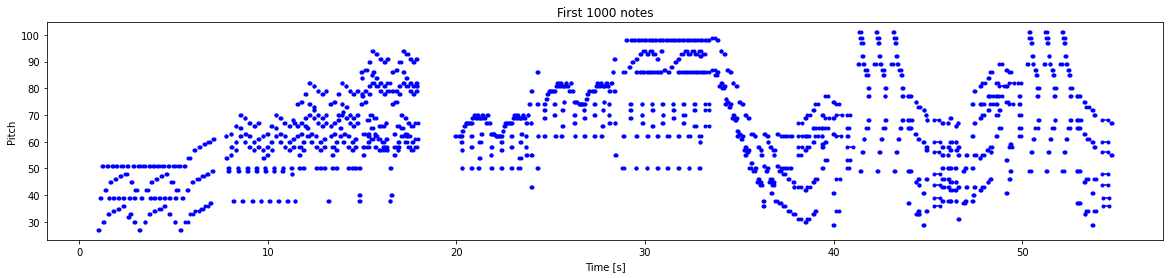

In [15]:
plot_piano_roll(raw_notes, count=1000)

Check the distribution of each note variable.

In [16]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

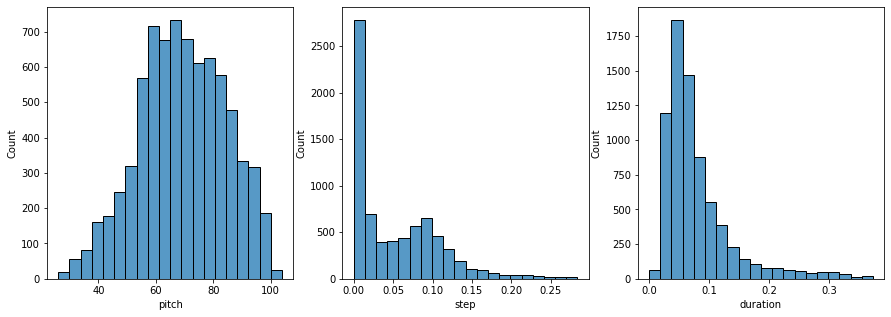

In [17]:
plot_distributions(raw_notes)

### **Create MIDI file from list of nodes**

We can generate a MIDI file from a list of notes using the function below. we are gonna need it in the prediction phase

In [18]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [19]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

 generated MIDI file 

In [20]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


## Create training Dataset

Creating the training dataset by extracting notes from the MIDI files. I started by using a small number of files, and experiment later with more. 

In [21]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [22]:
all_notes[:10]

,pitch,start,end,step,duration
0,69,0.997396,3.273438,0.000000,2.276042
1,62,1.020833,2.169271,0.023438,1.148437
2,65,1.022135,2.069010,0.001302,1.046875
3,50,1.023438,2.161458,0.001302,1.138021
4,60,1.947917,2.303385,0.924479,0.355469
5,64,1.953125,2.300781,0.005208,0.347656
6,62,2.549479,3.360677,0.596354,0.811198
7,59,2.582031,3.315104,0.032552,0.733073
8,52,2.592448,3.365885,0.010417,0.773438
9,68,3.123698,3.502604,0.531250,0.378906


In [23]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 45847


In [24]:
# Create a tf.data.Dataset from the parsed notes.
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [25]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2022-11-28 01:22:23.077472: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [26]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by `pretty_midi`.

Set the sequence length for each example. 

In [27]:
seq_length = 150
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(150, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [29]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [30]:
train_ds.element_spec

(TensorSpec(shape=(64, 150, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the models
The models will have three outputs, one for each note variable. 

In [31]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

### **LSTM model**

In [32]:
lstm_input_shape = (seq_length, 3)
lstm_learning_rate = 0.005

lstm_inputs = tf.keras.Input(lstm_input_shape)

# + LSTM (128) with return sequences 
x = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_inputs)
# + LSTM (128)
x = tf.keras.layers.LSTM(128)(x)
# + Dense (256) 
# + ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)

# Replace None with the appropriate output values (depending on vocabulary size)
lstm_outputs = {
  'pitch': tf.keras.layers.Dense(vocab_size, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

lstm_model = tf.keras.Model(lstm_inputs, lstm_outputs)

lstm_loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=lstm_learning_rate)

lstm_model.compile(loss=lstm_loss, optimizer=lstm_optimizer)

lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 3)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 150, 128)     67584       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          131584      lstm[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          33024       lstm_1[0][0]                     
______________________________________________________________________________________________

In [33]:
lstm_losses = lstm_model.evaluate(train_ds, return_dict=True)
lstm_losses

2022-11-28 01:22:35.772307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 36263 of 45697
2022-11-28 01:22:38.383040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


714/714 [==============================] - 117s 143ms/step - loss: 5.0203 - duration_loss: 0.1308 - pitch_loss: 4.8559 - step_loss: 0.0336


{'loss': 5.020291328430176,
 'duration_loss': 0.13079428672790527,
 'pitch_loss': 4.855881214141846,
 'step_loss': 0.03361739218235016}

One way balance this is to use the loss_weights argument to compile:

In [34]:
lstm_model.compile(
    loss=lstm_loss,
    loss_weights={
        'pitch': 0.02,
        'step': 1.0,
        'duration':0.2,
    },
    optimizer=lstm_optimizer,
)

In [35]:
lstm_model.evaluate(train_ds, return_dict=True)

714/714 [==============================] - 104s 143ms/step - loss: 0.1569 - duration_loss: 0.1308 - pitch_loss: 4.8559 - step_loss: 0.0336


{'loss': 0.15689390897750854,
 'duration_loss': 0.13079428672790527,
 'pitch_loss': 4.855881214141846,
 'step_loss': 0.03361739218235016}

In [36]:
lstm_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/lstm_ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 10

history_lstm = lstm_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=lstm_callbacks,
)

Epoch 1/10
714/714 [==============================] - 292s 410ms/step - loss: 0.0950 - duration_loss: 0.0583 - pitch_loss: 3.4764 - step_loss: 0.0138
Epoch 2/10
714/714 [==============================] - 290s 407ms/step - loss: 0.0944 - duration_loss: 0.0569 - pitch_loss: 3.4648 - step_loss: 0.0138
Epoch 3/10
714/714 [==============================] - 292s 409ms/step - loss: 0.0939 - duration_loss: 0.0569 - pitch_loss: 3.4575 - step_loss: 0.0134
Epoch 4/10
714/714 [==============================] - 292s 409ms/step - loss: 0.0930 - duration_loss: 0.0543 - pitch_loss: 3.4580 - step_loss: 0.0130
Epoch 5/10
714/714 [==============================] - 293s 411ms/step - loss: 0.0916 - duration_loss: 0.0541 - pitch_loss: 3.4166 - step_loss: 0.0125
Epoch 6/10
714/714 [==============================] - 299s 418ms/step - loss: 0.0903 - duration_loss: 0.0518 - pitch_loss: 3.4023 - step_loss: 0.0119
Epoch 7/10
714/714 [==============================] - 308s 432ms/step - loss: 0.0902 - duration_loss

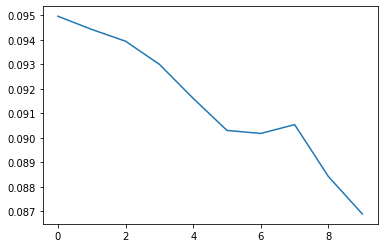

In [40]:
# Plot loss function
plt.plot(history_lstm.epoch, history_lstm.history['loss'], label='total loss')
plt.show()

According to my experiments results for different lengths also depend on value of files_num variable which is chosen during dataset creating. But in the general case it seems that length = 150 works better. The optimal value for this parameter can be found from different hyperparameters searching techniques.

## Generate notes

To use the model to generate notes, first we need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated.

In [41]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = keras_model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  #removing axes
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [69]:
for i in filenames:
    #filenames_test=filenames[i]
    raw_notes_test.append(midi_to_notes(i))
raw_notes_test.head()
len(raw_notes_test)

4914

### **LSTM model results**

In [70]:
temperature = 2.0
num_predictions = 100

sample_notes = np.stack([raw_notes_test[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes_lstm = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, lstm_model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes_lstm.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_lstm = pd.DataFrame(
    generated_notes_lstm, columns=(*key_order, 'start', 'end'))

In [64]:
generated_notes_lstm.head(10)

,pitch,step,duration,start,end
0,42,0.115352,0.235389,0.115352,0.350741
1,99,0.339097,0.545323,0.454449,0.999773
2,97,0.648377,0.612770,1.102826,1.715596
3,95,0.687511,0.920177,1.790337,2.710514
4,99,0.767214,1.116675,2.557551,3.674226
5,100,0.775610,1.092631,3.333160,4.425792
6,99,0.762583,1.029955,4.095744,5.125698
7,99,0.761600,0.985720,4.857344,5.843064
8,91,0.763625,0.946757,5.620969,6.567725
9,99,0.766360,0.940829,6.387329,7.328158


## The results 

In [71]:
out_file_lstm = 'output.mid'
out_pm_lstm = notes_to_midi(
    generated_notes_lstm, out_file=out_file_lstm, instrument_name=instrument_name)
display_audio(out_pm_lstm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Visualize the generated notes.

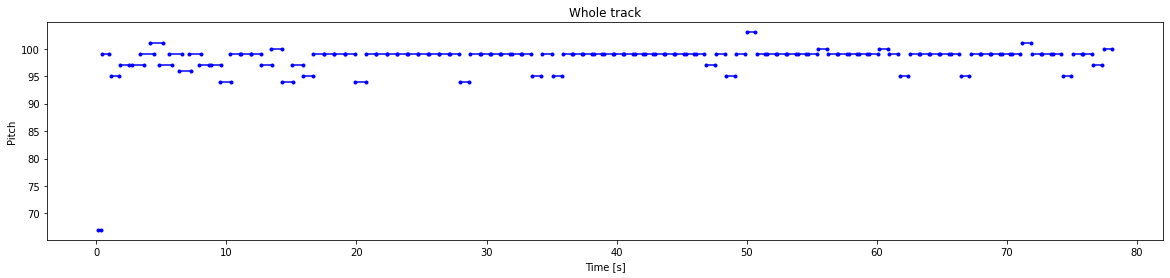

In [72]:
plot_piano_roll(generated_notes_lstm)

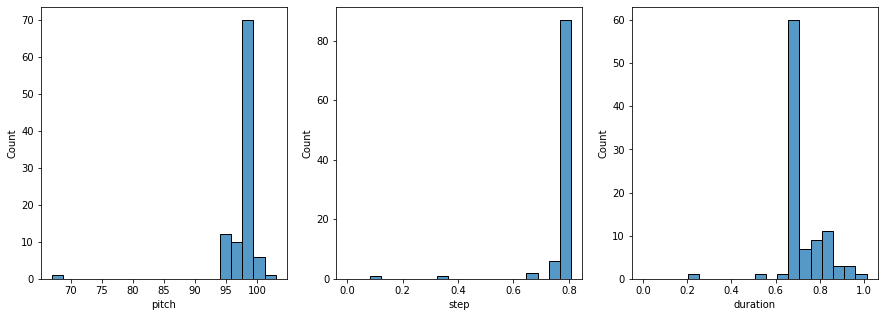

In [73]:
plot_distributions(generated_notes_lstm)